In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KDTree
import joblib, os
import time


In [2]:
dist_file = 'data/CLUSTER3_TRAIN_min_dist.csv'
dist_df = pd.read_csv(dist_file)

In [3]:
train_file = 'data/CLUSTER3_TRAIN_cleaned_cities.csv'
train_df = pd.read_csv(train_file, usecols = ['LC_CORINE'])

In [4]:
dist_scaled_df = dist_df/0.722033013807132
del dist_df

In [5]:
dist_scaled_df['LC_CORINE'] = train_df['LC_CORINE']
del train_df

In [6]:
dist_scaled_df['LC_CORINE'] = pd.to_numeric(dist_scaled_df['LC_CORINE'], downcast = 'integer')

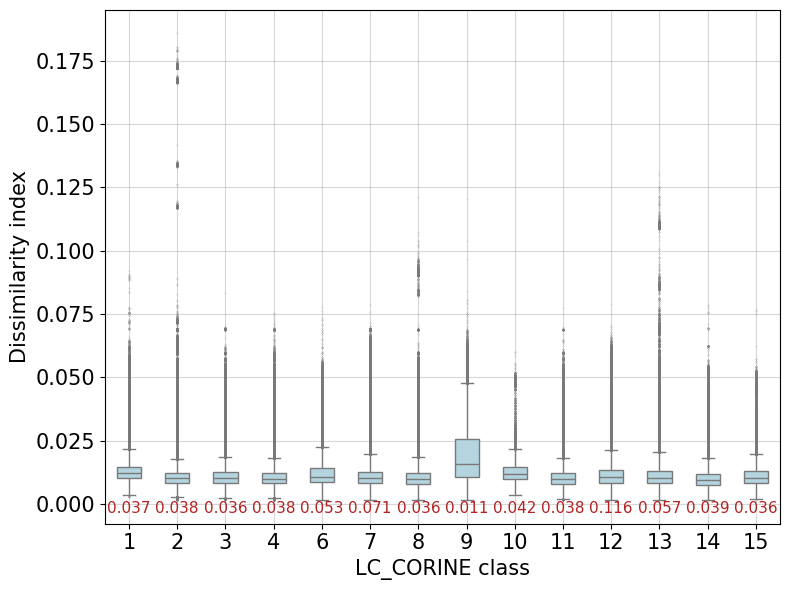

In [7]:
# Assuming dist_scaled_df is already defined and has one column 'dist'
# Add a column to indicate the label for plotting
#dist_scaled_df['label'] = 'Cluster 3'

plt.figure(figsize=(8, 6))

# Custom color palettes
#box_palette = {'Cluster 3': 'skyblue'}
#strip_palette = {'Cluster 3': 'steelblue'}

# Plot boxplot
ax = sns.boxplot(x='LC_CORINE', y='dist', data=dist_scaled_df, width=0.5, showfliers=True, fliersize = 0.1, color= "#add8e6")

# Plot stripplot
#sns.stripplot(x='label', y='dist', data=dist_scaled_df, jitter=True, alpha=0.7, edgecolor='black', palette=strip_palette)
grouped = dist_scaled_df.groupby('LC_CORINE')
for i, (label, group) in enumerate(grouped):
    q1 = group['dist'].quantile(0.25)
    q3 = group['dist'].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    lower_whisker = q1 - 1.5 * iqr
    outlier_count = np.round((group['dist'] > upper_whisker).sum()/len(group['dist']), decimals = 3)

    # Position of annotation (slightly above the upper whisker)
    y_pos = -0.0045
    ax.text(i, y_pos, f'{outlier_count}', ha='center', va='bottom', fontsize=11, color='firebrick')
del grouped

# Labels and layout
plt.xlabel('LC_CORINE class', fontsize=15)
plt.ylabel('Dissimilarity index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\kwint\AppData\Local\Temp\ipykernel_51012\3904622510.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dist_scaled_df.groupby(['LC_CORINE', 'LC_CORINE_LABEL'])


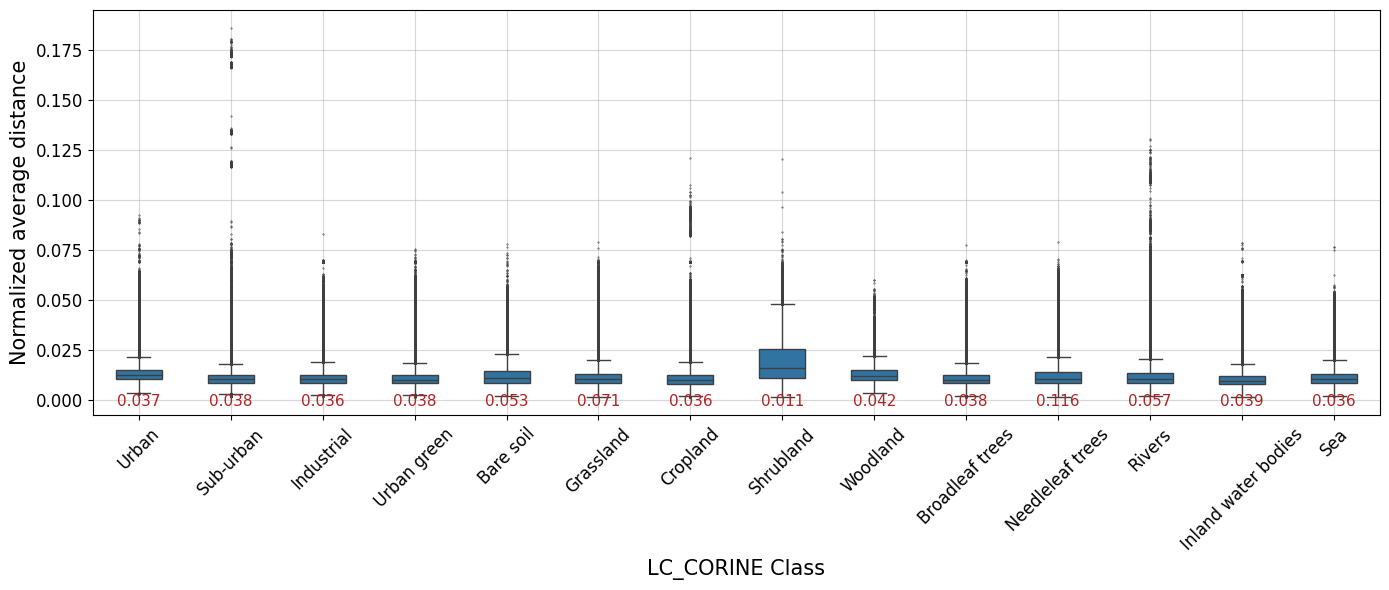

In [ ]:
# Assuming dist_scaled_df exists with 'dist' and 'LC_CORINE' columns

# Define labels and mapping (excluding class 5.0)
lc_labels = [
    "Urban", "Sub-urban", "Industrial", "Urban green",     # 1.0–4.0
    "Bare soil", "Grassland", "Cropland", "Shrubland",      # 6.0–9.0
    "Woodland", "Broadleaf trees", "Needleleaf trees",       # 10.0–12.0
    "Rivers", "Inland water bodies", "Sea"                  # 13.0–15.0
]
lc_class_numbers = [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
label_mapping = {k: v for k, v in zip(lc_class_numbers, lc_labels)}

# Map and filter
dist_scaled_df = dist_scaled_df[dist_scaled_df['LC_CORINE'] != 5.0].copy()
dist_scaled_df['LC_CORINE_LABEL'] = dist_scaled_df['LC_CORINE'].map(label_mapping)

# Set category order
dist_scaled_df['LC_CORINE_LABEL'] = pd.Categorical(
    dist_scaled_df['LC_CORINE_LABEL'],
    categories=lc_labels,
    ordered=True
)

plt.figure(figsize=(14, 6))

# Plot boxplot
ax = sns.boxplot(
    x='LC_CORINE_LABEL', 
    y='dist', 
    data=dist_scaled_df, 
    width=0.5, 
    showfliers=True, 
    fliersize=0.4
)

# Compute and annotate upper whiskers, collect thresholds
upper_whisker_data = []

grouped = dist_scaled_df.groupby(['LC_CORINE', 'LC_CORINE_LABEL'])
for i, ((code, label), group) in enumerate(grouped):
    q1 = group['dist'].quantile(0.25)
    q3 = group['dist'].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    outlier_count = np.round((group['dist'] > upper_whisker).sum() / len(group['dist']), 3)

    # Save threshold
    upper_whisker_data.append({'LC_CORINE': code, 'Threshold': upper_whisker})

    # Annotate on plot
    y_pos = -0.0045
    ax.text(i, y_pos, f'{outlier_count}', ha='center', va='bottom', fontsize=11, color='firebrick')

# Ensure output directory exists
os.makedirs('results', exist_ok=True)

# Write thresholds to CSV
thresholds_df = pd.DataFrame(upper_whisker_data)
thresholds_df.to_csv('results/Thresholds_AOA_CL3.csv', index=False)

# Finalize plot
plt.xlabel('LC_CORINE Class', fontsize=15)
plt.ylabel('Dissimilarity index', fontsize=15)
plt.xticks(rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


In [2]:

# Columns to use
columns_order = [
    'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
    'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
    'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
]

# Load min-max scaling info and ensure correct matching
min_max_df = pd.read_csv("data/CLUSTER3_min_max.csv", sep=';')
min_max_df.set_index(min_max_df.columns[0], inplace=True)

# Ensure all required columns exist in the min-max file
missing_cols = [col for col in columns_order if col not in min_max_df.index]
if missing_cols:
    raise ValueError(f"The following required columns are missing in total_min_max.csv: {missing_cols}")

# Get min/max values in the same order as columns_order
min_vals = min_max_df.loc[columns_order, 'min'].astype(float).to_numpy()
max_vals = min_max_df.loc[columns_order, 'Max'].astype(float).to_numpy()

# Avoid division by zero
scale = max_vals - min_vals
scale[scale == 0] = 1.0

def min_max_scale(data, min_vals, scale):
    return (data - min_vals) / scale

In [3]:
# Load importances
importances_df = pd.read_csv('AOA_data/importances_CL3.csv')
importances_df.set_index('Feature', inplace=True)

# Map feature names to column names in test_scaled
importance_to_column_map = {
    'IMPERV': 'IMPERV',
    'HEIGHT': 'HEIGHT',
    'COAST': 'COAST',
    'ELEV': 'ELEV',
    'POP': 'POP',
    'RH': 'RH',
    'SP': 'SP',
    'PRECIP': 'PRECIP',
    'T_2M': 'T_2M_COR',  # Important mapping
    'wind_speed': 'WS',
    'TCC': 'TCC',
    'CAPE': 'CAPE',
    'BLH': 'BLH',
    'SSR': 'SSR',
    'SOLAR_ELEV': 'SOLAR_ELEV',
    'DECL': 'DECL'
}

# Build weights array in the same order as test_scaled columns
weights = np.array([
    importances_df.loc[feature, 'Importance'] 
    for feature in importance_to_column_map 
    if importance_to_column_map[feature] in columns_order
])


In [4]:
# Assume these are already defined
# from your_scaling_module import min_max_scale, min_vals, scale

columns_order = [
    'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
    'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
    'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
]
category_column = 'LC_CORINE'
for i in np.arange(1,16):
    print(f"working on category: {i}")
    target_category_value = i  # Change as needed

    csv_path = 'data/CLUSTER3_TRAIN_cleaned_cities.csv'
    chunksize = 1_000_000

    # Collect filtered data
    filtered_data = []
    chunk_idx = 0
    chunk_start_time = time.time()
    # Stream through the CSV
    for chunk in pd.read_csv(csv_path, usecols=columns_order + [category_column], chunksize=chunksize):
        chunk_idx += 1
        # Filter rows for the desired category
        matches = chunk[chunk[category_column] == target_category_value]
        
        if not matches.empty:
            scaled = min_max_scale(matches[columns_order].to_numpy(), min_vals, scale) * weights
            filtered_data.append(pd.DataFrame(scaled))

        duration = time.time() - chunk_start_time
        print(f"Chunk {chunk_idx} processed in {duration:.2f}s")
        chunk_start_time = time.time()

    # Combine all matching rows into one DataFrame
    if filtered_data:
        combined_df = pd.concat(filtered_data, ignore_index=True)
        #train_scaled = min_max_scale(combined_df.to_numpy(), min_vals, scale)*weights
        tree = KDTree(combined_df, leaf_size=40)

        # Save KDTree to disk
        os.makedirs('trees', exist_ok=True)
        os.makedirs('trees/CL3', exist_ok=True)
        tree_path = f'trees/CL3/CLUSTER3_KDTREE_{target_category_value}.joblib'
        joblib.dump(tree, tree_path)

        print(f"KDTree saved to: {tree_path}")
    else:
        print(f"No data found for LC_CORINE == {target_category_value}")

working on category: 1
Chunk 1 processed in 3.42s
Chunk 2 processed in 3.70s
Chunk 3 processed in 3.77s
Chunk 4 processed in 4.04s
Chunk 5 processed in 3.87s
Chunk 6 processed in 3.74s
Chunk 7 processed in 3.73s
Chunk 8 processed in 3.99s
Chunk 9 processed in 3.82s
Chunk 10 processed in 3.53s
Chunk 11 processed in 3.44s
Chunk 12 processed in 3.65s
Chunk 13 processed in 3.51s
Chunk 14 processed in 3.35s
Chunk 15 processed in 3.52s
Chunk 16 processed in 3.84s
Chunk 17 processed in 3.79s
Chunk 18 processed in 3.56s
Chunk 19 processed in 3.45s
Chunk 20 processed in 3.64s
Chunk 21 processed in 3.33s
Chunk 22 processed in 3.20s
Chunk 23 processed in 3.20s
Chunk 24 processed in 3.31s
Chunk 25 processed in 3.15s
Chunk 26 processed in 3.20s
Chunk 27 processed in 3.33s
Chunk 28 processed in 3.28s
Chunk 29 processed in 3.26s
Chunk 30 processed in 3.29s
Chunk 31 processed in 3.18s
Chunk 32 processed in 3.16s
Chunk 33 processed in 3.14s
Chunk 34 processed in 3.37s
Chunk 35 processed in 3.10s
Chunk 

# Example

In [4]:
file_path = r"data/raster_total/total_Brussels.csv"
data = pd.read_csv(file_path)

In [5]:
data = data.dropna()
data['SP'] = 105021.266
data['RH'] = 0
data['PRECIP'] = 0
data['WS'] = 0
data['T_2M_COR'] = 316.73102
data['TCC'] = 0
data['BLH'] = 9.957261
data['SSR'] = 0
data['SOLAR_ELEV'] = -76.284645
data['DECL'] = 0
data['CAPE'] = 4909.0205
data = data.reset_index()

In [6]:

# Columns to use
columns_order = [
    'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP',  
    'RH', 'SP', 'PRECIP', 'T_2M_COR', 'WS', 'TCC',  
    'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL'
]

# Load min-max scaling info and ensure correct matching
min_max_df = pd.read_csv("data/CLUSTER3_min_max.csv", sep=';')
min_max_df.set_index(min_max_df.columns[0], inplace=True)

# Ensure all required columns exist in the min-max file
missing_cols = [col for col in columns_order if col not in min_max_df.index]
if missing_cols:
    raise ValueError(f"The following required columns are missing in CLUSTER3_min_max.csv: {missing_cols}")

# Get min/max values in the same order as columns_order
min_vals = min_max_df.loc[columns_order, 'min'].astype(float).to_numpy()
max_vals = min_max_df.loc[columns_order, 'Max'].astype(float).to_numpy()

# Avoid division by zero
scale = max_vals - min_vals
scale[scale == 0] = 1.0

def min_max_scale(data, min_vals, scale):
    return (data - min_vals) / scale

In [7]:
# Load importances
importances_df = pd.read_csv('AOA_data/importances_CL3.csv')
importances_df.set_index('Feature', inplace=True)

# Map feature names to column names in test_scaled
importance_to_column_map = {
    'IMPERV': 'IMPERV',
    'HEIGHT': 'HEIGHT',
    'COAST': 'COAST',
    'ELEV': 'ELEV',
    'POP': 'POP',
    'RH': 'RH',
    'SP': 'SP',
    'PRECIP': 'PRECIP',
    'T_2M': 'T_2M_COR',  # Important mapping
    'wind_speed': 'WS',
    'TCC': 'TCC',
    'CAPE': 'CAPE',
    'BLH': 'BLH',
    'SSR': 'SSR',
    'SOLAR_ELEV': 'SOLAR_ELEV',
    'DECL': 'DECL'
}

# Build weights array in the same order as test_scaled columns
weights = np.array([
    importances_df.loc[feature, 'Importance'] 
    for feature in importance_to_column_map 
    if importance_to_column_map[feature] in columns_order
])


In [32]:
new_data = data
new_data['SP'] = 100000
new_data['RH'] = 50
new_data['PRECIP'] = 3
new_data['WS'] = 1
new_data['T_2M_COR'] = 290
new_data['TCC'] = 0.3
new_data['BLH'] = 1000
new_data['SSR'] = 0
new_data['SOLAR_ELEV'] = 0
new_data['DECL'] = 0
new_data['CAPE'] = 100

In [33]:


# Scale numerical features
data_scaled = min_max_scale(new_data[columns_order].to_numpy(), min_vals, scale)
weighted_features = data_scaled * weights
lc_values = new_data['LC_CORINE'].values

# Initialize distances for this chunk
data_dists = np.full(len(new_data), np.inf)
distances_list = []

category_start_time = time.time()
# For each class in this new_data, query the corresponding KDTree
for lc_class in np.unique(lc_values):
    print(f'Working on class: {lc_class}')
    tree_path = f'trees/CL3/CLUSTER3_KDTREE_{lc_class}.joblib'
    current_tree = joblib.load(tree_path)

    mask = lc_values == lc_class
    query_points = weighted_features[mask]

    # Query KDTree
    dists, _ = current_tree.query(query_points, k=1)
    data_dists[mask] = dists.flatten()

    duration = time.time() - category_start_time
    print(f"CORINE class {lc_class} processed in {duration:.2f}s")
    category_start_time = time.time()

# Save distances
distances_list.append(pd.DataFrame(data_dists, columns=['dist']))


Working on class: 1
CORINE class 1 processed in 1.00s
Working on class: 2
CORINE class 2 processed in 43.84s
Working on class: 3
CORINE class 3 processed in 5.35s
Working on class: 4
CORINE class 4 processed in 3.04s
Working on class: 6
CORINE class 6 processed in 0.18s
Working on class: 7
CORINE class 7 processed in 3.40s
Working on class: 8
CORINE class 8 processed in 19.25s
Working on class: 10
CORINE class 10 processed in 0.27s
Working on class: 11
CORINE class 11 processed in 6.37s
Working on class: 12
CORINE class 12 processed in 0.47s
Working on class: 13
CORINE class 13 processed in 0.17s
Working on class: 14
CORINE class 14 processed in 0.33s


In [34]:
distances_list[0]

,dist
0,0.013501
1,0.013487
2,0.013480
3,0.013504
4,0.013846
...,...
104226,0.017014
104227,0.017119
104228,0.017179
104229,0.017014


In [35]:
distances_list = distances_list[0]/0.722033013807132

In [36]:
new_data['dists'] = distances_list

In [38]:
thresholds_path = 'results/Thresholds_AOA_CL3.csv'
thresholds = pd.read_csv(thresholds_path)


In [39]:
data_AOA = np.full(len(new_data), np.inf)
AOA_list = []
category_start_time = time.time()
for lc_class in np.unique(lc_values):

    mask = lc_values == lc_class
    points = new_data[mask]

    new = points['dists'] <= thresholds['Threshold'][lc_class-1]

    data_AOA[mask] = new

    duration = time.time() - category_start_time
    print(f"CORINE class {lc_class} processed in {duration:.2f}s")
    category_start_time = time.time()

# Save distances
AOA_list.append(pd.DataFrame(data_AOA, columns=['AOA']))


CORINE class 1 processed in 0.01s
CORINE class 2 processed in 0.01s
CORINE class 3 processed in 0.00s
CORINE class 4 processed in 0.00s
CORINE class 6 processed in 0.00s
CORINE class 7 processed in 0.00s
CORINE class 8 processed in 0.01s
CORINE class 10 processed in 0.00s
CORINE class 11 processed in 0.00s
CORINE class 12 processed in 0.00s
CORINE class 13 processed in 0.00s
CORINE class 14 processed in 0.00s


In [43]:
new_data['AOA'] = AOA_list[0]

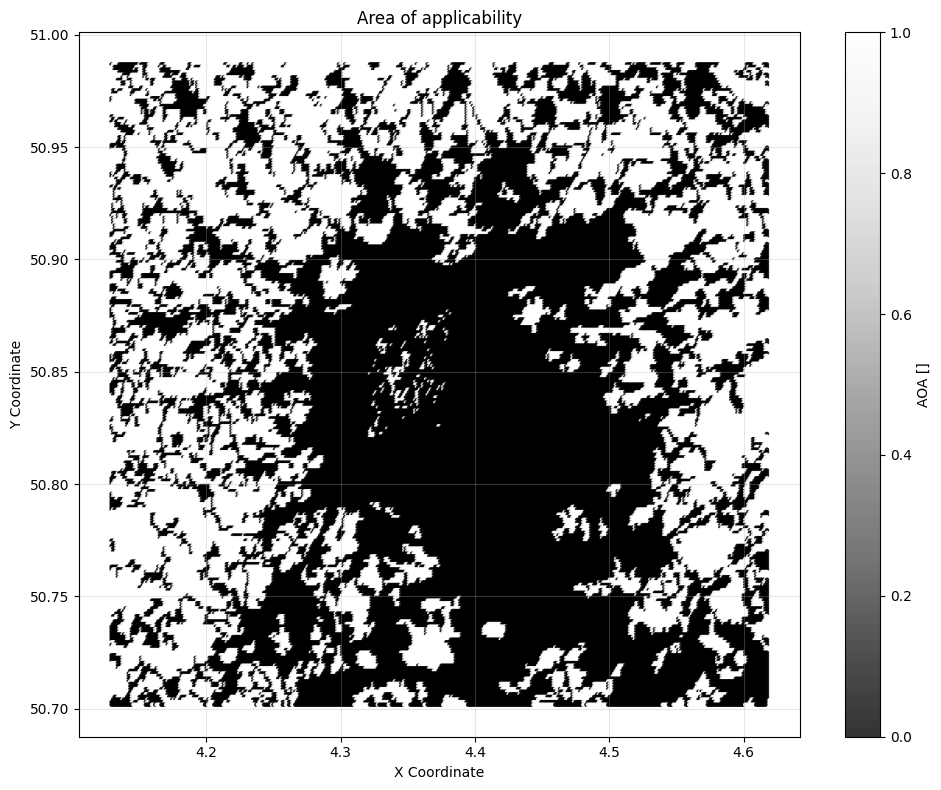

In [54]:

plt.figure(figsize=(10, 8))
sc = plt.scatter(new_data['x'], data['y'], c=data['AOA'], cmap = 'Greys_r', s=5, alpha=0.8)
plt.colorbar(sc, label='AOA []')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Area of applicability')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()